## Smoking model

Value iteration converged after 192 iterations.


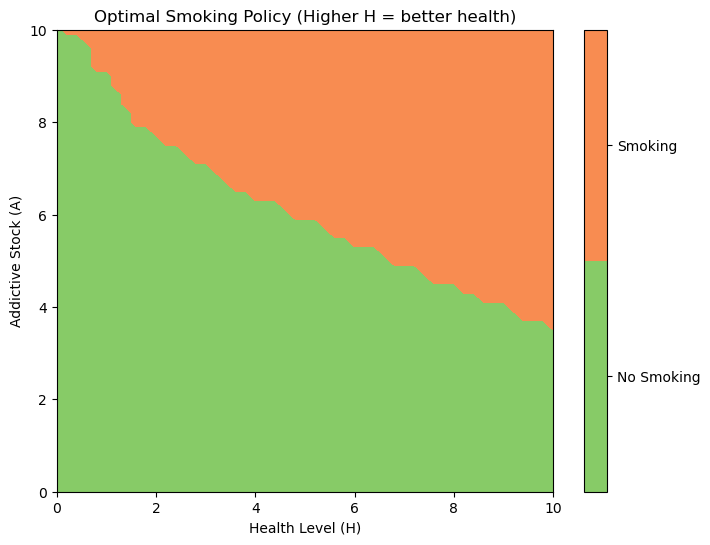

In [17]:
import numpy as np
import matplotlib.pyplot as plt

u = 2.0           # Baseline enjoyment from smoking
theta = 0.02      # Reinforcement effect weight (quadratic in A)
phi = 0.95        # Retention rate of addiction
beta = 0.1        # Increase in addiction when smoking
eta = 0.9         # Base health depreciation per period (if not smoking)
gamma = 0.2       # Additional health depreciation from smoking
delta = 0.95      # Discount factor
cost_smoking = 2.0  # Explicit monetary cost of smoking
mu = 0.5

# Health utility function: higher H gives more utility.
def health_utility(H):
    # For example, we might assume utility is concave in health.
    return mu * H**(1/2)

# Grids for state variables:
A_min, A_max, A_steps = 0, 10, 51  # addiction
H_min, H_max, H_steps = 0, 10, 51    # health level (higher is better)
A_grid = np.linspace(A_min, A_max, A_steps)
H_grid = np.linspace(H_min, H_max, H_steps)

# Initialize value function and policy
V = np.zeros((A_steps, H_steps))
policy = np.zeros((A_steps, H_steps), dtype=int)  # 0: no smoking, 1: smoking

tol = 1e-4
max_iter = 1000

def find_nearest_index(x, grid):
    return np.abs(grid - x).argmin()
A_mesh, H_mesh = np.meshgrid(A_grid, H_grid, indexing='ij')


# Value iteration: here, the immediate utility depends on current health.
for iteration in range(max_iter):
    V_new = np.copy(V)
    diff = 0.0
    for i, A in enumerate(A_grid):
        for j, H in enumerate(H_grid):
            value_actions = np.zeros(2)
            
            # Action 0: Not smoking
            # Immediate utility: utility from current health.
            immediate_0 = health_utility(H)
            # Transition: addiction decays; health depreciates at base rate.
            A_next_0 = phi * A
            H_next_1 = H * eta  # ensure health doesn't drop below 0
            i_next_0 = find_nearest_index(A_next_0, A_grid)
            j_next_0 = find_nearest_index(H_next_0, H_grid)
            continuation_0 = V[i_next_0, j_next_0]
            value_actions[0] = immediate_0 + delta * continuation_0
            
            # Action 1: Smoking
            # Immediate utility: enjoyment from smoking plus current health utility,
            # minus explicit monetary cost.
            # You could also include a reinforcement term; for instance, theta * A or theta * A^2.
            immediate_1 = u + theta * A**2 + health_utility(H) - cost_smoking
            # Transition: addiction increases; health deteriorates faster.
            A_next_1 = A  
            H_next_1 = H * (eta - gamma)
            i_next_1 = find_nearest_index(A_next_1, A_grid)
            j_next_1 = find_nearest_index(H_next_1, H_grid)
            continuation_1 = V[i_next_1, j_next_1]
            value_actions[1] = immediate_1 + delta * continuation_1
            
            best_action = np.argmax(value_actions)
            V_new[i, j] = value_actions[best_action]
            policy[i, j] = best_action
            
            diff = max(diff, np.abs(V_new[i, j] - V[i, j]))
    V = V_new
    if diff < tol:
        print(f"Value iteration converged after {iteration+1} iterations.")
        break
else:
    print("Value iteration did not converge.")

# Plot the optimal policy: 0: No Smoking, 1: Smoking
plt.figure(figsize=(8,6))
plt.contourf(H_mesh, A_mesh, policy, levels=[-0.5,0.5,1.5], cmap='RdYlGn_r')
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking','Smoking'])
plt.xlabel('Health Level (H)')
plt.ylabel('Addictive Stock (A)')
plt.title('Optimal Smoking Policy (Higher H = better health)')
plt.show()


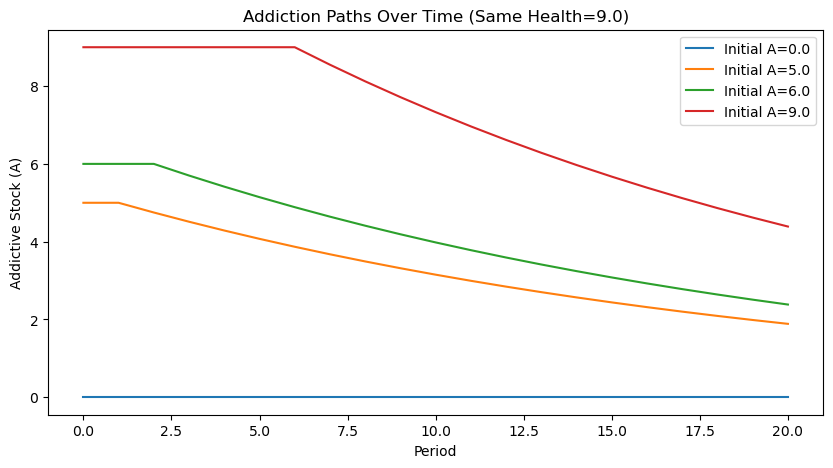

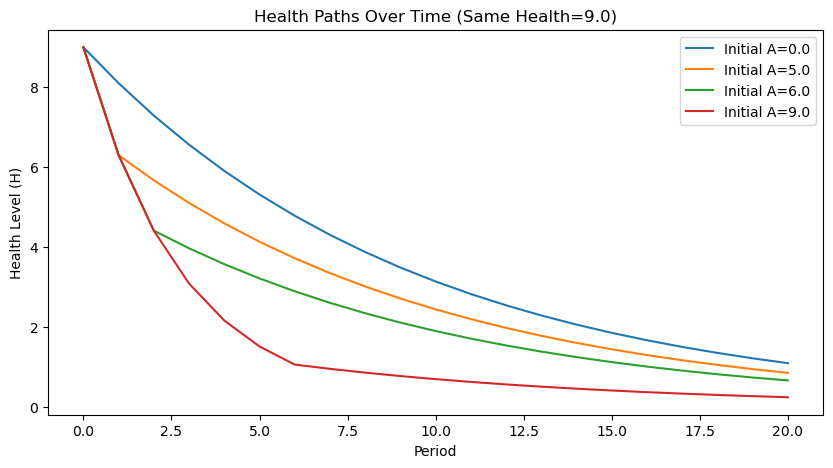

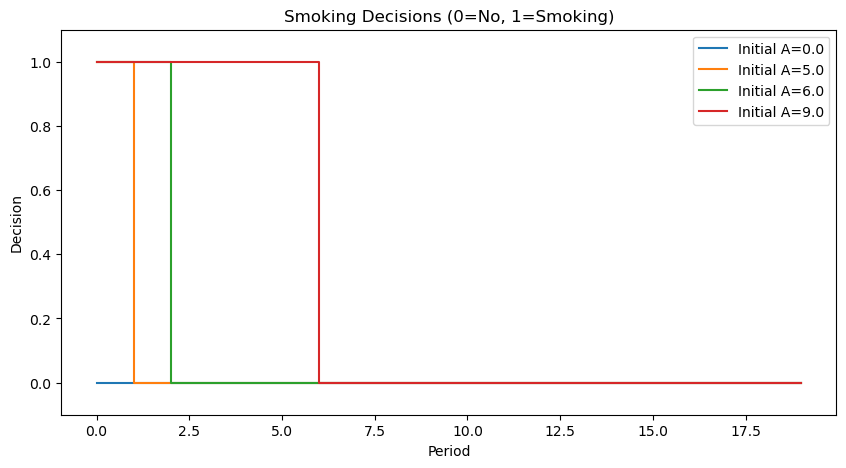

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. SIMULATION PARAMETERS
# -----------------------------
T = 20  # Number of periods to simulate
initial_health = 9.0  # Same health for all agents
initial_addictions = [0.0, 5.0, 6.0, 9.0]  # Different initial addictions

# Prepare arrays to store simulation results for each initial addiction
n_sims = len(initial_addictions)
sim_A = np.zeros((n_sims, T+1))
sim_H = np.zeros((n_sims, T+1))
sim_d = np.zeros((n_sims, T), dtype=int)

def find_nearest_index(x, grid):
    return np.abs(grid - x).argmin()

# -----------------------------
# 2. RUN THE SIMULATIONS
# -----------------------------
for idx, A0 in enumerate(initial_addictions):
    sim_A[idx, 0] = A0
    sim_H[idx, 0] = initial_health
    for t in range(T):
        # Find the nearest indices in the grid for the current state (A, H)
        i_idx = find_nearest_index(sim_A[idx, t], A_grid)
        j_idx = find_nearest_index(sim_H[idx, t], H_grid)
        
        # Get the optimal decision from your policy array (0 or 1)
        d = policy[i_idx, j_idx]
        sim_d[idx, t] = d
        
        # Update addiction and health based on the chosen action
        if d == 0:
            # No smoking
            A_next = phi * sim_A[idx, t]
            H_next = sim_H[idx, t] * eta
        else:
            # Smoking
            # NOTE: in your code snippet, you do not actually add beta to addiction
            #       If you want to build addiction, do: A_next = sim_A[idx, t] + beta
            A_next = sim_A[idx, t]  
            H_next = sim_H[idx, t] * (eta - gamma)
        
        sim_A[idx, t+1] = A_next
        # Ensure health does not go below zero
        sim_H[idx, t+1] = max(H_next, 0)

# -----------------------------
# 3. PLOT THE SIMULATION RESULTS
# -----------------------------
# Plot addiction paths
plt.figure(figsize=(10,5))
for idx, A0 in enumerate(initial_addictions):
    plt.plot(range(T+1), sim_A[idx, :], label=f"Initial A={A0}")
plt.title("Addiction Paths Over Time (Same Health=9.0)")
plt.xlabel("Period")
plt.ylabel("Addictive Stock (A)")
plt.legend()
plt.show()

# Plot health paths
plt.figure(figsize=(10,5))
for idx, A0 in enumerate(initial_addictions):
    plt.plot(range(T+1), sim_H[idx, :], label=f"Initial A={A0}")
plt.title("Health Paths Over Time (Same Health=9.0)")
plt.xlabel("Period")
plt.ylabel("Health Level (H)")
plt.legend()
plt.show()

# Plot decisions
plt.figure(figsize=(10,5))
for idx, A0 in enumerate(initial_addictions):
    plt.step(range(T), sim_d[idx, :], where='post', label=f"Initial A={A0}")
plt.title("Smoking Decisions (0=No, 1=Smoking)")
plt.xlabel("Period")
plt.ylabel("Decision")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()
